In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [1]:
import tensorflow as tf

# Check if TensorFlow is using GPU
print("Is TensorFlow using GPU:", tf.config.list_physical_devices('GPU'))


Is TensorFlow using GPU: []


In [3]:
#Import helper_functions
import requests

url = 'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py'
response = requests.get(url)

# Save the file locally
with open('helper_functions.py', 'wb') as file:
    file.write(response.content)

print("Download complete!")


Download complete!


In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [4]:

dataset_list = tfds.list_builders() #Get all datasets in tfd
print("food101" in dataset_list) #Check if "food101" is in tfd

True


**Load the data**

In [5]:
(train_data, test_data), ds_info = tfds.load(name = "food101",
                                             split = ["train", "validation"],
                                             shuffle_files= True,
                                             as_supervised= True, #get data in tuple format (data, label)
                                             with_info= True) 

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [7]:
# Find the class names
class_names = ds_info.features["label"].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [8]:
# Take one sample of the train data
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
for image, label in train_one_sample:
    print(f'''
    Image shape : {image.shape}
    Image datatype : {image.dtype}
    Target class from food101 : {label}
    Class name : {class_names[label.numpy()]}
    ''')


    Image shape : (512, 512, 3)
    Image datatype : <dtype: 'uint8'>
    Target class from food101 : 77
    Class name : pork_chop
    


In [10]:
# Check the range of each pixel (0-255) or (0-1) 

tf.reduce_max(image), tf.reduce_min(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=255>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=0>)

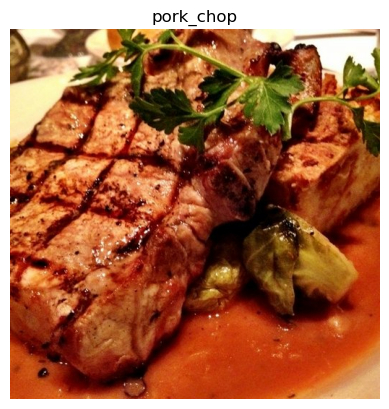

In [11]:
# Plot the image

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis("off");

In [12]:
# Make preprocessing images function

def preprocess_image(image, label, img_shape = 224):
    """
    Convert images datatype from unit8 to float32 
    and reshape images
    """

    image = tf.image.resize(image, [img_shape,img_shape])
    return tf.cast(image, tf.float32), label






In [13]:
preprocessed_img = preprocess_image(image, label, img_shape = 224)[0]
preprocessed_img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 69.69388  ,  32.69388  ,  16.693878 ],
        [ 78.44898  ,  41.44898  ,  22.520409 ],
        [ 78.35204  ,  42.566326 ,  16.137754 ],
        ...,
        [211.34154  , 166.91301  , 141.69875  ],
        [172.38239  , 127.382385 , 104.382385 ],
        [138.04063  ,  93.040634 ,  72.040634 ]],

       [[ 63.693874 ,  28.290815 ,  10.499998 ],
        [ 60.137756 ,  25.137754 ,   3.2857132],
        [ 68.54082  ,  33.484695 ,   5.198978 ],
        ...,
        [208.20901  , 164.19371  , 136.76518  ],
        [184.3518   , 140.48448  , 113.76002  ],
        [146.6731   , 104.673096 ,  79.74452  ]],

       [[ 62.142857 ,  30.142857 ,   8.438776 ],
        [ 61.795918 ,  27.739798 ,   2.280612 ],
        [ 64.43878  ,  29.39286  ,   1.62245  ],
        ...,
        [160.42403  , 119.85259  ,  88.96486  ],
        [191.30092  , 150.72949  , 120.08663  ],
        [157.9994   , 118.999405 ,  87.57084  ]],

       ...,

     

In [14]:
# Map preprocess function to train data
train_data = train_data.map(map_func= preprocess_image, num_parallel_calls= tf.data.AUTOTUNE)

# Shuffle train data and turn it into batches and prefetch it
train_data = train_data.shuffle(buffer_size= 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

# Map preprocess function to test data
test_data = test_data.map(map_func= preprocess_image, num_parallel_calls= tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [15]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [16]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
 
mixed_precision.set_global_policy("mixed_float16") # Set global data policy to mixed precision

```python
Build feature extraction model
```


In [17]:


# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

# Create functional model
inputs = tf.keras.layers.Input(shape= input_shape, name= "input_layer")
x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation("softmax", dtype = tf.float32, name = "softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(0.0001),
              metrics = ["accuracy"])

In [18]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

In [19]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [21]:
# Fit the model

history = model.fit(train_data,
                    epochs = 3,
                    steps_per_epoch = len(train_data),
                    validation_data = test_data,
                    validation_steps = int(0.15 * len(test_data)),
                    callbacks = [early_stopping,
                                 reduce_lr])

Epoch 1/3
   9/2368 ━━━━━━━━━━━━━━━━━━━━ 37:33 955ms/step - accuracy: 0.0111 - loss: 4.7410

KeyboardInterrupt: 

```python
Save the model
```

In [39]:
model.save("food101model.keras")

```python
Evaluating the model
```

In [ ]:
results = model.evaluate(test_data)

In [ ]:
y_pred = model.predict(test_data)
pred_classes = y_pred.argmax(axis = 1)

In [ ]:
y_labels = []

for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
 
ConfusionMatrixDisplay.from_predictions(y_true=y_labels,
                                        y_pred=pred_classes,
                                        display_labels=class_names,
                                        cmap="Blues",
                                        xticks_rotation="vertical",
                                        # make it bigger
                                        ax=plt.figure(figsize=(50, 50),
                                                      dpi=150).subplots())

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_labels,pred_classes))